# AB Testing Statistics

### Academic References
* Cohen, [Statistical Power Analsysis for the Behavioral Sciences (1988)](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf), pg 201
* Chow, [Sample Size Calculations in Clinical Research (2008)](https://www.mobt3ath.com/uplode/book/book-43792.pdf), page 89 

### R packages
* [pwr](https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html)
* [pwrAB](https://cran.r-project.org/web/packages/pwrAB/pwrAB.pdf)

### Website References
* https://en.wikipedia.org/wiki/A/B_testing (https://en.wikipedia.org/wiki/A/B_testing)
* https://en.wikipedia.org/wiki/Fisher%27s_exact_test (https://en.wikipedia.org/wiki/Fisher%27s_exact_test)
* https://byrony.github.io/understanding-ab-testing-and-statistics-behind.html (https://byrony.github.io/understanding-ab-testing-andstatistics-behind.html)
* https://www.evanmiller.org/ab-testing/sample-size.html (https://www.evanmiller.org/ab-testing/sample-size.html)
* https://multithreaded.

In [20]:
library(Hmisc)

### Setup experiment

In [21]:
clicks_A = 59; clicks_B = 35
impressions_A = 78; impressions_B = 68
nonClicks_A = impressions_A - clicks_A
nonClicks_B = impressions_A - clicks_B
pA <- clicks_A / impressions_A
pB <- clicks_B / impressions_B

### Display data

In [22]:
Clicks <- c(clicks_A, clicks_B)
Impressions <- c(impressions_A, impressions_B)
NonClicks <- Impressions - Clicks
ad <- data.frame(Clicks, NonClicks, Impressions)
print(ad)

  Clicks NonClicks Impressions
1     59        19          78
2     35        33          68


### AB Significance: fisher test
* commonly considered when sample sizes are small, but can be used when large as well

In [23]:
fisher.test = fisher.test(data.frame(A=c(clicks_A,impressions_A), B=c(clicks_B,impressions_B)))
fisher.test


	Fisher's Exact Test for Count Data

data:  data.frame(A = c(clicks_A, impressions_A), B = c(clicks_B, impressions_B))
p-value = 0.1819
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8378326 2.5901025
sample estimates:
odds ratio 
  1.467222 


In [24]:
if(fisher.test$p.value > 0.05) {
paste("We see from above that there are not enough tests (ie, pval ~ ",round(fisher.test$p.value,3),")")
} else {
paste("We have enough datapoints!")
}

[1] "We see from above that there are not enough tests (ie, pval ~  0.182 )"

### AB Significance: chi-squared test
* commonly considered when sample sizes are large
* Go here (https://www.evanmiller.org/ab-testing/chi-squared.html) for online comparison

In [25]:
chi.test = chisq.test(ad[1:2, 1:2], correct = FALSE)
chi.test


	Pearson's Chi-squared test

data:  ad[1:2, 1:2]
X-squared = 9.2554, df = 1, p-value = 0.002348


In [26]:
if(chi.test$p.value > 0.05) {
paste("We see from above that there are not enough tests (ie, pval ~ ",round(chi.test$p.value,3),")")
} else {
paste("We have enough datapoints!")
}

[1] "We have enough datapoints!"

### AB Significance: power proportion test

In [27]:
prop.test(c(clicks_A,clicks_B),c(impressions_A,impressions_B), alternative="two.sided")


	2-sample test for equality of proportions with continuity correction

data:  c(clicks_A, clicks_B) out of c(impressions_A, impressions_B)
X-squared = 8.2313, df = 1, p-value = 0.004117
alternative hypothesis: two.sided
95 percent confidence interval:
 0.07567432 0.40773443
sample estimates:
   prop 1    prop 2 
0.7564103 0.5147059 


### Size calculation (equal groups)
* Notes:
    * The Minimum Detectable Effect is the smallest effect that will be detected (1-β)% of the time
    * Exercise 6.1 p. 198 from Cohen (1988) (http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)
* Alternatively, to do yourself, go here (https://www.evanmiller.org/ab-testing/sample-size.html) for simple online calculator
* For other power tests go here (https://www.statmethods.net/stats/power.html)

In [28]:
baseline <- pA # baseline conversion rate
delta <- pA-pB # minimum detectable effect
power <- 0.8 # specificity, or true negative rate (1-beta)
sig_level <- 0.05 # false positive rate
result <- power.prop.test( p1 = baseline, p2 = pB,
power = power, sig.level = sig_level,
alternative = "two.sided" )
update_impressions = round(result$n)
result


     Two-sample comparison of proportions power calculation 

              n = 61.04515
             p1 = 0.7564103
             p2 = 0.5147059
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


### Size calculation plot

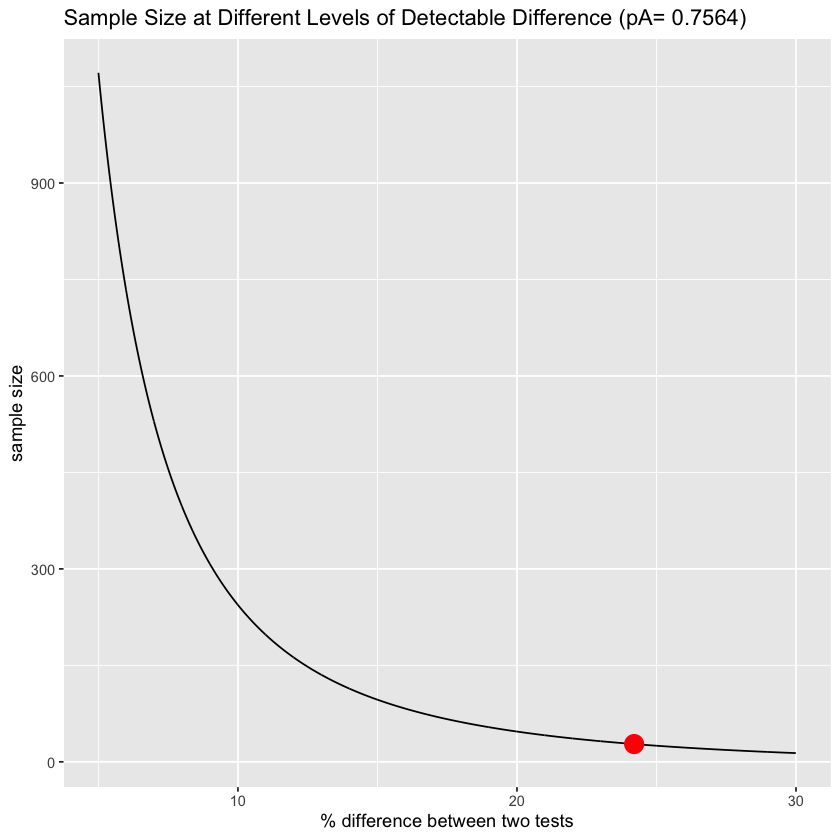

In [29]:
library(scales)
library(ggplot2)
p1 <- pA # baseline rate
b <- 0.8 # power
a <- 0.05 # significance level
dd <- seq(from = 0.05, to = 0.3, by = 0.0001) # detectable differences
result <- data.frame(matrix(nrow = length(dd), ncol = 2))
names(result) <- c("DD", "ni")
for (i in 1:length(dd)) {
result[i, "DD"] <- 100*dd[i]
result[i, "ni"] <- power.prop.test(sig.level = a, p1 = p1, p2 = p1 + dd[i], alternative = 'two.sided', power = b)$n
}
ggplot(data = result, aes(x = DD, y = ni)) +
ggtitle(paste0("Sample Size at Different Levels of Detectable Difference (pA= ",round(pA,4),")")) +
geom_line() + ylab("sample size") + xlab("% difference between two tests") +
geom_point(data = result[result$DD == abs(100*round(pA-pB,3)),], aes(x = DD, y = ni), colour ="red", size = 5)

### Size calculation (unequal groups)

In [30]:
s = bsamsize(pA, pB, fraction=impressions_A/(impressions_A + impressions_B), power=.8)
new_impressions_A = round(as.numeric(s[1]))
new_impressions_B = round(as.numeric(s[2]))
paste("We need", new_impressions_A - impressions_A, "more impressions in A")
paste("We need", new_impressions_B - impressions_B, "more impressions in B")

[1] "We need -13 more impressions in A"

[1] "We need -11 more impressions in B"

### Size calculation: Two Proportion Z-Test
* Chow S, Shao J, Wang H. 2008. Sample Size Calculations in Clinical Research. 2nd Ed. Chapman & Hall/CRC Biostatistics Series. page 89 (https://www.mobt3ath.com/uplode/book/book-43792.pdf)
* Can also go here (http://www.ayujournal.org/article.asp?issn=0974-8520;year=2014;volume=35;issue=2;spage=119;epage=123;aulast=Binu)
* samp size = 2[ S*(z(1-alpha) - z(1-beta)) / difference ]^2

In [31]:
#kappa=impressions_A/impressions_B
kappa=1
alpha=0.05
beta=0.20
zAct = (pA-pB)/sqrt(pA*(1-pA)/impressions_B/kappa+pB*(1-pB)/impressions_B)
power = 100*round(pnorm(zAct-qnorm(1-alpha/2))+pnorm(-zAct-qnorm(1-alpha/2)),3)
paste("We are confident that", power, "% of the detections are True when H0 is actually rejected")

[1] "We are confident that 85.7 % of the detections are True when H0 is actually rejected"

In [32]:
nB = (pA*(1-pA)/kappa+pB*(1-pB))*((qnorm(1-alpha/2)+qnorm(1-beta))/(pA-pB))^2
nA = kappa*nB
z=(pA-pB)/sqrt(pA*(1-pA)/nB/kappa+pB*(1-pB)/nB)
p_val = 2*pnorm(abs(z), lower.tail = F)
Power=pnorm(z-qnorm(1-alpha/2))+pnorm(-z-qnorm(1-alpha/2))
paste("We need", round(nB), "impressions per group")

[1] "We need 58 impressions per group"

### Size calculation: Two Proportion Test using Cohen Effect Size
* use pwr (https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html) R package
* math is here (https://ncss-wpengine.netdna-ssl.com/wpcontent/themes/ncss/pdf/Procedures/PASS/Tests_for_Two_Proportions_using_Effect_Size.pdf)

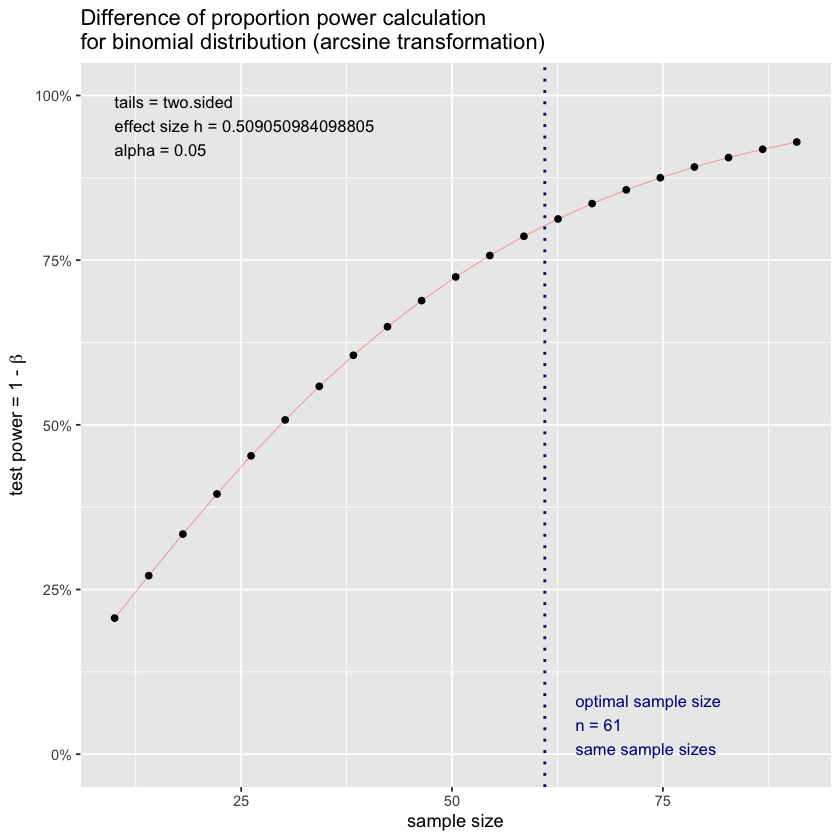

In [33]:
library(pwr)
p.out = pwr.2p.test(h = ES.h(p1 = pA, p2 = pB), sig.level = 0.05, power = 0.80)
plot(p.out)

In [34]:
p.out = pwr.2p.test(h = ES.h(p1 = pA, p2 = pB), sig.level = 0.05, n = impressions_A)
power = 100*round(p.out$power,3)
paste("We are confident that", power, "% of the detections are True when H0 is actually rejected")

[1] "We are confident that 88.9 % of the detections are True when H0 is actually rejected"

* Maximum accepted type II error (false neg. rate) should be (beta = 20%)
* According to this test, we are getting (power = 89%)
* Meaning for 89% of the detections are True when the alternative is actually rejected (so since the standard power > 80%, this is a good test)

In [35]:
library(pwrAB)
p.out = AB_t2n_prop(prop_A = pA, prop_B = pB,percent_B = .5, power = 0.8, sig_level = .05, alternative = 'two_sided')
paste("We need", round(p.out$N/2), "impressions per group")

[1] "We need 59 impressions per group"

### Simulate new test using updated sample size

In [36]:
new_clicks_B = round(clicks_B*update_impressions/impressions_B)
new_clicks_A = round(clicks_A*update_impressions/impressions_A)
fisher.test(data.frame(A=c(new_clicks_A,new_impressions_B), B=c(new_clicks_B,new_impressions_B)))


	Fisher's Exact Test for Count Data

data:  
p-value = 0.2364
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.794327 2.782421
sample estimates:
odds ratio 
  1.480773 


### Simulation (with N experiments)

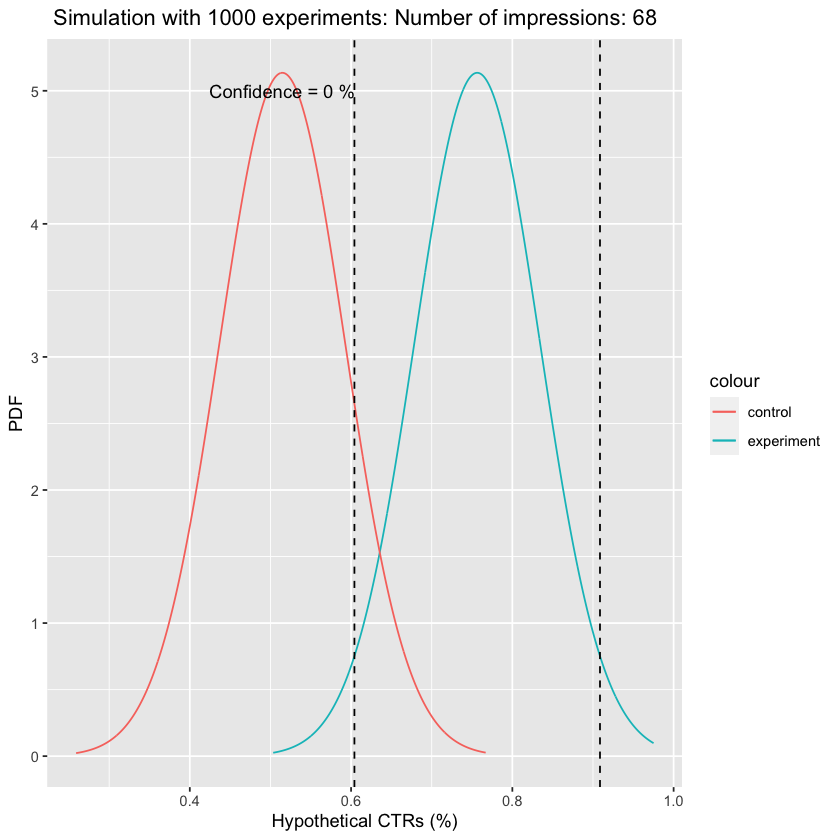

In [37]:
nTrials = 1000
muA = pA
sdPooled = sqrt( (pA*(1-pA)/impressions_A) + (pB*(1-pB)/impressions_B))
simA = sort(rnorm(nTrials,mean=muA,sdPooled))
simA = seq(from=min(simA), to=max(simA), length.out=nTrials)
distA = dnorm(simA, mean = muA, sd = sdPooled)
alphas = qnorm(c(0.025,0.975), mean = muA, sd = sdPooled, lower.tail = TRUE, log.p = FALSE)
muB = pB
simB = sort(rnorm(nTrials,mean=muB,sdPooled))
simB = seq(from=min(simB), to=max(simB), length.out=nTrials)
distB <- dnorm(simB, mean = muB, sd = sdPooled)
dat <- data.frame("simA" = simA, "control" = distA, "simB" = simB, "experiment" = distB,
"lwr"= alphas[1], "upr"= alphas[2])
power = round(100*sum(dat[dat$simB > alphas[2],]$experiment)/sum(dat$experiment),1)
p = ggplot(data = dat) +
ggtitle(paste(" Simulation with",nTrials,"experiments: Number of impressions:",impressions_B)) +
geom_line(aes_string(x = "simA", y = "control", color=shQuote('experiment'))) +
geom_line(aes_string(x = "simB", y = "experiment", color=shQuote('control'))) +
geom_vline(aes(xintercept=as.numeric(alphas[1])), linetype="dashed", size = 0.5) +
geom_vline(aes(xintercept=as.numeric(alphas[2])), linetype="dashed", size = 0.5) +
#geom_ribbon(data=dat[dat$simB > alphas[2],],aes(x=simB, ymin=0,ymax=experiment),fill="green",alpha=0.2) +
annotate("text", x = pB, y = 5, label = paste("Confidence =",power,"%")) + 
ylab("PDF") + xlab("Hypothetical CTRs (%)")
p
